# Singularities in the direct adjoint term
One primary difficulty is that singularities that are present in the direct adjoint (and solar) terms. The direct solar term is a delta function in direction, uniformly over the domain.  However, the direct adjoint term will have delta functions that vary over the domain.  

## Visualization in 2D
Using a simple 2D geometry, this notebook shows the kind of delta function that we expect to encounter.  Here we consider detectors with a finite solid angle of view, but a singular location that is far above the top of the domain. 

![adjoint source singularity](./dplot.png)

We can see that When these adjoint sources are streamed through the domain, each pixel spreads delta functions over a cone of points in the solid angle of sight. 


## Equation for calculating with the direct term
The direct adjoint term can be written as follows: 
\begin{equation}
\mathbf{w}_{0}(x, v) = \sum_{m}A_m(x)\mathbb{1}\left\{\frac{x_{m}^{*} - x}{|x_{m}^{*}-x|}\dot v_{m}^{*}<(1 - \epsilon_{m}^{*})\right\}\delta\left(v - \frac{x_{m}^{*}-x}{|x_{m}^{*}-x|}\right) \mathbf{q_{\odot}^{m}}
\end{equation}

To compute this we can store an array of indexes and weights at each spatial grid point.  For each gridpoint $x^{k}$, we need the indexes of pixels that see the gridpoint.  We can call this index set, $\mathcal{M}_{k}$ for the $k$th gridpoint.  We also, need to compute the weight $A_{mk}$ which accounts for all scale factors (extinction along the path, the residual, etc.).  This gives the following expression:
\begin{equation}
\mathbf{w}_0(x^{k}, v) = \sum_{m\in \mathcal{M}_{k}}A_{mk}\delta\left(v - \frac{x_{m}^{*}-x}{|x_{m}^{*}-x|}\right) \mathbf{q_{\odot}^{m}}\\
\end{equation}
Computationally, we will need to evaluate the scattering matrix at the outgoing directions in the delta function. 



In [1]:
%matplotlib inline

import matplotlib 
import scipy as sp
import matplotlib.pyplot as plt


In [2]:

# Domain 
NX = 32
XMIN = 0.
XMAX = 50.
NZ = 5
ZMIN = 0.
ZMAX = 10.

# Plotting parameters
WIDTH = 0.0025#3#4125
SCALE = 40


# Sun parameters
SZA = sp.pi / 8.0
VZSUN = -sp.cos(SZA)
VXSUN = -sp.sin(SZA)

# Detector parameters
DET_EPS = 0.025#25
DET_X = sp.linspace(2.5, 18, 3)
DET_Z = 25 * sp.ones_like(DET_X)
COLLOC_X = 15. 
COLLOC_Z = 12.5




In [3]:
# define the spatial grid
x = sp.linspace(XMIN, XMAX, NX)
z = sp.linspace(ZMIN, ZMAX, NZ)
xx, zz = sp.meshgrid(x, z)


In [4]:
# define the directional sensitivity of a detector
px = DET_X #sp.linspace(5, 20, 3)
pz = DET_Z #sp.ones_like(px) * 25.

# direction of view (from center on the ground)
vx, vz = [px-COLLOC_X, pz-COLLOC_Z]
vnorm = sp.sqrt(vx**2 + vz**2)
vx /= vnorm
vz /= vnorm


pixels = sp.array([px, pz, vx, vz])

# Determine if a point is viewed
def bool_viewed(pixel, xx, zz, eps=DET_EPS):
    "Return an array shaped like xx and zz.  True when in pixel."
    px, pz, vx, vz = pixel
    
    _vx = px - xx
    _vz = pz - zz
    _vnorm = sp.sqrt(_vx**2 + _vz**2)
    _vx *= 1.0 / _vnorm
    _vz *= 1.0 / _vnorm
    
    # Determine if the point is in the solid angle of view
    out = _vx*vx + _vz*vz >= (1-eps) * sp.ones_like(xx)
    
    return out.flatten(), _vx.flatten(), _vz.flatten()    

view1, vx1, vz1 = bool_viewed(pixels[:, 0], xx, zz)
view2, vx2, vz2 = bool_viewed(pixels[:, 1], xx, zz)
view3, vx3, vz3 = bool_viewed(pixels[:, 2], xx, zz)

xxflat = xx.flatten()
zzflat = zz.flatten()

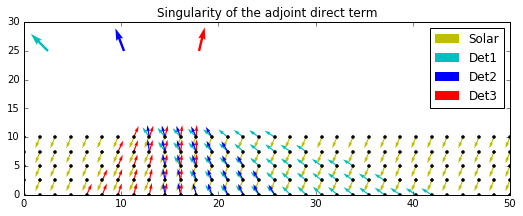

In [5]:
fig = plt.figure(0, figsize=(7.5, 3), facecolor='white')
ax = fig.add_axes([.05, .1, .9, .8])


#Plot the grid and solar direct delta function 
ax.plot(xxflat, zzflat, color='k', marker='.', linewidth=0)
ax.quiver(xxflat, zzflat, VXSUN, VZSUN, 
          color='y', width=WIDTH, scale=SCALE, label='Solar')

# Plot the detector delta functions
ax.quiver(xxflat[view1], zzflat[view1], vx1[view1], vz1[view1], 
          color='c', width=WIDTH, scale=SCALE, label='Det1')
ax.quiver(xxflat[view2], zzflat[view2], vx2[view2], vz2[view2], 
          color='b', width=WIDTH, scale=SCALE, label='Det2')
ax.quiver(xxflat[view3], zzflat[view3], vx3[view3], vz3[view3], 
          color='r', width=WIDTH, scale=SCALE, label='Det3')
for pixel, c in zip(pixels.T, ['c', 'b', 'r']):
    ax.quiver(*pixel, color=c, width=2*WIDTH, scale = SCALE/2.0)
#ax.quiver(*pixels, linewidth=.5)


ax.set_ybound(ZMIN - 0.0 * (DET_Z[0] * (0.2)), DET_Z[0] * (1+0.2))#yticks([0,10, 20, 30,])
ax.set_xbound([XMIN, XMAX])
ax.legend()
ax.set_title("Singularity of the adjoint direct term")

fig.savefig('dplot.png')